<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Using the Landlab NetworkSedimentTransporter component

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

This tutorial illustrates how to model the transport of coarse sediment through a synthetic river network using the NetworkSedimentTransporter Landlab component. 

For an equivalent tutorial demonstrating initialization of the NetworkSedimentTransporter with a *shapefile river network*, <a href="http://localhost:8888/notebooks/Documents/GitHub/landlab/notebooks/tutorials/network_sediment_transporter/network_sediment_transporter_shapefile_network.ipynb">click here</a></small>
.

In this example we will: 
- create a synthetic Landlab grid to represent a river network
- create sediment "parcels" that will transport through the river network, represented as items in a Landlab DataRecord
- run the component
- plot the results of the model run

Import the necessary libraries, plus a bit of magic so that we can plot within this notebook:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph
from landlab.plot import plot_network_and_parcels

%matplotlib inline

## 1. Create the river network model grid

First, we need to create a Landlab NetworkModelGrid to represent the river network. Each link on the grid represents a reach of river. Each node represents a break between reaches. All tributary junctions must be associated with grid nodes. 

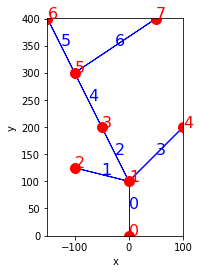

In [2]:
y_of_node = (0, 100, 200, 200, 300, 400, 400, 125)
x_of_node = (0, 0, 100, -50, -100, 50, -150, -100)

nodes_at_link = ((1, 0), (2, 1), (1, 7), (3, 1), (3, 4), (4, 5), (4, 6))

grid = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)

plt.figure(0)
graph.plot_graph(grid, at="node,link")

Our network consists of seven links between 8 nodes. X and Y, above, represent the plan-view coordinates of the node locations. Notes_at_link describes the node indices that are connedted by each link. For example, link 2 connects node 1 and node 7. 

Next, we need to populate the grid with the relevant topographic information: 

In [3]:
grid.at_node["topographic__elevation"] = [0.0, 0.08, 0.25, 0.15, 0.25, 0.4, 0.8, 0.8]
grid.at_node["bedrock__elevation"] = [0.0, 0.08, 0.25, 0.15, 0.25, 0.4, 0.8, 0.8]

grid.at_link["flow_depth"] = 2.5 * np.ones(grid.number_of_links) # m
grid.at_link["reach_length"] = 200*np.ones(grid.number_of_links) # m
grid.at_link["channel_width"] = 1*np.ones(grid.number_of_links) # m

We must distinguish between topographic elevation (the top surface of the bed sediment) and bedrock elevation (the surface of the river in the absence of modeled sediment). 

Note that "reach_length" is defined by the user, rather than calculated as the minimum distance between nodes. This accounts for channel sinuosity. 


## 2. Create sediment 'parcels' in a DataRecord

We represent sediment in the network as discrete parcels (or packages) of grains of uniform size and characteristics. Each parcel is tracked through the network grid according to sediment transport and stratigraphic constraints. 

Parcels are tracked using the Landlab <a href="http://localhost:8888/notebooks/Documents/GitHub/landlab/notebooks/tutorials/data_record/DataRecord_tutorial.ipynb">DataRecord</a>. 

First, let's create arrays with all of the essential sediment parcel variables: 

In [4]:
# element_id is the link on which the parcel begins. 
element_id = np.repeat(np.arange(grid.number_of_links),30)
element_id = np.expand_dims(element_id, axis=1)

volume = 0.05*np.ones(np.shape(element_id))  # (m3)
active_layer = np.ones(np.shape(element_id)) # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id)) # (mass loss /m)

# Lognormal GSD
medianD = 0.085 # m
mu = np.log(medianD)
sigma = np.log(2) #assume that D84 = sigma*D50
np.random.seed(0)
D = np.random.lognormal(
    mu,
    sigma,
    np.shape(element_id)
)  # (m) the diameter of grains in each parcel

In order to track sediment motion, we classify parcels as either active (representing mobile surface sediment) or inactive (immobile subsurface) during each timestep. The active parcels are the most recent parcels to arrive in the link. During a timestep, active parcels are transported downstream (increasing their `location_in_link`, which ranges from 0 to 1) according to a sediment transport formula. 

We begin by assigning each parcel an arbitrary (and small) arrival time and location in the link. 

In [5]:
time_arrival_in_link = np.random.rand(np.size(element_id), 1) 
location_in_link = np.random.rand(np.size(element_id), 1) 

In addition to the required parcel attributes listed above, you can designate optional parcel characteristics, depending on your needs. For example: 

In [6]:
lithology = ["quartzite"] * np.size(element_id)

We now collect the arrays into a dictionary of variables, some of which will be tracked through time (`["item_id", "time"]`), and others of which will remain constant through time :

In [7]:
variables = {
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "lithology": (["item_id"], lithology),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume)
}

With all of the required attributes collected, we can create the parcels DataRecord. Often, parcels will eventually transport off of the downstream-most link. To track these parcels, we have designated a "`dummy_element`" here, which has index value `-2`. 

In [8]:
items = {"grid_element": "link", "element_id": element_id}

_OUT_OF_NETWORK = NetworkModelGrid.BAD_INDEX - 1

parcels = DataRecord(
    grid,
    items=items,
    time=[0.0],
    data_vars=variables,
    dummy_elements={"link": [_OUT_OF_NETWORK]},
)

## 3. Run the NetworkSedimentTransporter

With the parcels and grid set up, we can move on to setting up the model. 

In [9]:
timesteps = 10 # total number of timesteps
dt = 60 * 60 * 24 *1 # length of timestep (seconds) 

Before running the NST, we need to determine flow direction on the grid (upstream and downstream for each link). To do so, we initalize and run a Landlab flow director component: 

In [10]:
fd = FlowDirectorSteepest(grid, "topographic__elevation")
fd.run_one_step()

Then, we initialize the network sediment transporter: 

In [11]:
nst = NetworkSedimentTransporter(    
    grid,
    parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)

Now we are ready to run the model forward in time: 

In [12]:
for t in range(0, (timesteps * dt), dt):
    nst.run_one_step(dt)    
    print("Model time: ", t/dt, "timesteps passed")

Model time:  0.0 timesteps passed
Model time:  1.0 timesteps passed
Model time:  2.0 timesteps passed
Model time:  3.0 timesteps passed
Model time:  4.0 timesteps passed
Model time:  5.0 timesteps passed
Model time:  6.0 timesteps passed
Model time:  7.0 timesteps passed
Model time:  8.0 timesteps passed
Model time:  9.0 timesteps passed


## 4. Plot the model results


There are landlab plotting tools specific to the `NetworkSedimentTransporter`. In particular, `plot_network_and_parcels` creates a plan-view map of the network and parcels (represented as dots along the network). We can color both the parcels and the links by attributes.  

Here, we demonstrate one example use of `plot_network_and_parcels`, which creates a plan-view map of the network and parcels (represented as dots along the network). We can color both the parcels and the links by attributes. For a thorough tutorial on the plotting tools, see <a href="http://localhost:8888/notebooks/Documents/GitHub/landlab/notebooks/tutorials/network_sediment_transporter/network_plotting_examples.ipynb">this notebook</a>.   

Below, each link (represented as a line) is colored by the total volume of sediment on the link. Each parcel is colored by the parcel grain size. 

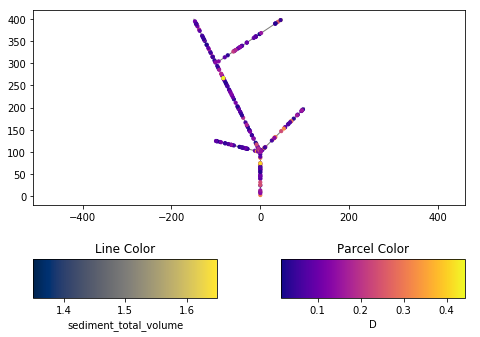

In [13]:
fig = plot_network_and_parcels(
    grid, parcels, 
    parcel_time_index=0, 
    parcel_color_attribute="D",
    link_attribute="sediment_total_volume", 
    parcel_size=10, 
    parcel_alpha=1.0)

In addition, the results of the NST can be visualized by directly accessing information about the grid, the parcels, and by accessing variables stored after the run of NST. 

As a simple example, we can plot the total transport distance of all parcels through the model run as a function of parcel diameter. 

Text(0, 0.5, 'Cumulative parcel travel distance')

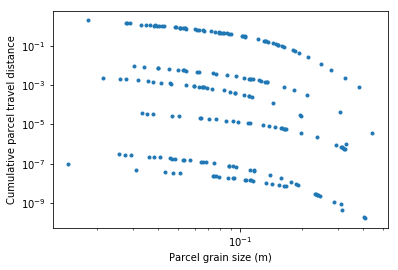

In [15]:
plt.loglog(parcels.dataset.D[:,-1],
         nst._distance_traveled_cumulative,
         '.'
        )
plt.xlabel('Parcel grain size (m)')
plt.ylabel('Cumulative parcel travel distance')

# Note: some of the smallest grain travel distances can exceed the length of the 
# grid by "overshooting" during a single timestep of high transport rate


Great, smaller parcels transport farther! 

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>